# Mount google drive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# cd /content/drive/MyDrive/Colab Notebooks/quantitative_trading

# Install

In [3]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 10.3 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
! pip install backtrader backtrader_plotting

     |████████████████████████████████| 410 kB 7.6 MB/s 
     |████████████████████████████████| 60 kB 8.1 MB/s 


In [5]:
! pip install git+https://github.com/quantopian/pyfolio

  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-un43gnnz
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-un43gnnz
     |████████████████████████████████| 52 kB 1.3 MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-py3-none-any.whl size=75774 sha256=f82078184ae4176063619d4f7386a5ff5f64d6e13f49dbc3e9fc4edba6d321b2
  Stored in directory: /tmp/pip-ephem-wheel-cache-7t46nto9/wheels/2d/aa/24/c99ed55ef37c69e33815248c1622cdb81b65ec753868004c28
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39780 sha256=ca06c693bd8bf00c0a4e2c50f9559f29b12fbc71d7857851b994f8c64cd653a3
  Stored in directory: /root/.cache/pip/wheels/d9/91/4b/654fcff57477efcf149eaca236da2fce991526cbab431bf312
Successfully built pyfolio empyrical


In [6]:
# ! wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz && \
#   tar -xvzf ta-lib-0.4.0-src.tar.gz && \
#   cd ta-lib/ && \
#   ./configure --prefix=/usr && \
#   make && \
#   make install
# ! pip install TA-Lib
# ! rm -R ta-lib ta-lib-0.4.0-src.tar.gz

# Import modules

In [7]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime 
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import backtrader as bt
from backtrader_plotting import Bokeh
from backtrader_plotting.schemes import Tradimo
import pyfolio as pf

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
# pandas_datareader

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


# Get data

In [8]:
# Request historical data
data = yf.Ticker("NVDA").history(period='max')
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1999-01-22,0.401824,0.448464,0.356379,0.376709,271468800.0,0.0,0.0
1999-01-25,0.406607,0.420958,0.376709,0.416174,51048000.0,0.0,0.0
1999-01-26,0.420958,0.429329,0.377905,0.383885,34320000.0,0.0,0.0
1999-01-27,0.385081,0.394649,0.363554,0.382690,24436800.0,0.0,0.0
1999-01-28,0.382689,0.385081,0.379101,0.381494,22752000.0,0.0,0.0
...,...,...,...,...,...,...,...
2022-03-07,228.169998,230.330002,213.300003,213.520004,45082100.0,0.0,0.0
2022-03-08,213.089996,223.729996,206.500000,215.139999,55746700.0,0.0,0.0
2022-03-09,223.869995,232.199997,222.470001,230.139999,49274200.0,0.0,0.0


In [9]:
data.dtypes

Open            float64
High            float64
Low             float64
Close           float64
Volume          float64
Dividends       float64
Stock Splits    float64
dtype: object

# Implementation Shortfall

# Backtesting

In [10]:
class SmaCross(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=30   # period for the slow moving average
    )

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal

    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0:  # if fast crosses slow to the upside
                self.buy()  # enter long

        elif self.crossover < 0:  # in the market & cross to the downside
            self.close()  # close long position

In [11]:
class SimpleMeanReversion(bt.Strategy):
 
    '''
    This is a simple mean reversion bollinger band strategy.
 
    Entry Critria:
        - Long:
            - Price closes below the lower band
            - Stop Order entry when price crosses back above the lower band
        - Short:
            - Price closes above the upper band
            - Stop order entry when price crosses back below the upper band
    Exit Critria
        - Long/Short: Price touching the median line
    '''
 
    params = dict(
        period=20,
        devfactor=2,
        size=20
        )
 
    def __init__(self):
        self.boll = bt.indicators.BollingerBands(period=self.p.period, devfactor=self.p.devfactor)
        #self.sx = bt.indicators.CrossDown(self.data.close, self.boll.lines.top)
        #self.lx = bt.indicators.CrossUp(self.data.close, self.boll.lines.bot)
 
    def next(self):
        orders = self.broker.get_orders_open() 
        # Cancel open orders so we can track the median line
        if orders:
            for order in orders:
                self.broker.cancel(order)
 
        if not self.position:
            if self.data.close > self.boll.lines.top:
                self.sell(exectype=bt.Order.Stop, price=self.boll.lines.top[0], size=self.p.size)
            if self.data.close < self.boll.lines.bot:
                self.buy(exectype=bt.Order.Stop, price=self.boll.lines.bot[0], size=self.p.size)
        else:
            if self.position.size > 0:
                self.sell(exectype=bt.Order.Limit, price=self.boll.lines.mid[0], size=self.p.size)
 
            else:
                self.buy(exectype=bt.Order.Limit, price=self.boll.lines.mid[0], size=self.p.size)
 
    def notify_trade(self,trade):
        if trade.isclosed:
            dt = self.data.datetime.date()
 

In [12]:
class TradeClosed(bt.analyzers.Analyzer):
    """
    Analyzer returning closed trade information.
    """

    def start(self):
        super(TradeClosed, self).start()

    def create_analysis(self):
        self.rets = {}
        self.vals = tuple()

    def notify_trade(self, trade):
        """Receives trade notifications before each next cycle"""
        if trade.isclosed:
            self.vals = (
                self.strategy.datetime.datetime(),
                trade.data._name,
                round(trade.pnl, 2),
                round(trade.pnlcomm, 2),
                trade.commission,
                # trade.baropen,trade.barclose,
                (trade.dtclose - trade.dtopen),
                trade.status
            )
            self.rets[trade.ref] = self.vals
    def get_analysis(self):
        return self.rets

In [13]:
class forexSpreadCommisionScheme(bt.CommInfoBase):
    '''
    This commission scheme attempts to calcuate the commission hidden in the
    spread by most forex brokers. It assumes a mid point data is being used.

    *New Params*
    spread: Float, the spread in pips of the instrument
    JPY_pair: Bool, states whether the pair being traded is a JPY pair
    acc_counter_currency: Bool, states whether the account currency is the same
    as the counter currency. If false, it is assumed to be the base currency
    '''
    params = (
        # ('commission', 5),
        ('spread', 2.0),
        ('stocklike', False),
        ('JPY_pair', False),
        ('acc_counter_currency', True),
        ('commtype', bt.CommInfoBase.COMM_FIXED),
        )

    def _getcommission(self, size, price, pseudoexec):
        '''
        This scheme will apply half the commission when buying and half when selling.
        If JPY pair change the multiplier accordingly.
        If account currency is same as the base currency, change pip value calc.
        '''
        if self.p.JPY_pair == True:
            multiplier = 0.01
        else:
            multiplier = 0.0001

        if self.p.acc_counter_currency == True:
            comm = abs((self.p.spread * (size * multiplier)/2))

        else:
            comm =  abs((self.p.spread * ((size / price) * multiplier)/2))

        return comm

In [39]:
data = bt.feeds.PandasData(dataname=yf.download('9449.T', '2010-01-01', '2021-12-01'))
print("type:", type(data))
print("data:", data)
data.__dict__

[*********************100%***********************]  1 of 1 completed
type: <class 'backtrader.feeds.pandafeed.PandasData'>
data: <backtrader.feeds.pandafeed.PandasData object at 0x7fe0e9801f10>


{'_barstack': deque([]),
 '_barstash': deque([]),
 '_colmapping': {'close': 'Close',
  'datetime': None,
  'high': 'High',
  'low': 'Low',
  'open': 'Open',
  'openinterest': None,
  'volume': 'Volume'},
 '_compression': 1,
 '_dataname':               Open    High     Low   Close    Adj Close  Volume
 Date                                                           
 2010-01-04   375.0   380.0   373.0   376.0   299.458252  102300
 2010-01-05   380.0   380.0   376.0   377.0   300.254547  127600
 2010-01-06   377.0   380.0   375.0   378.0   301.051056  175000
 2010-01-07   379.0   379.0   375.0   376.0   299.458252  200400
 2010-01-08   376.0   378.0   375.0   375.0   298.661804  156200
 ...            ...     ...     ...     ...          ...     ...
 2021-11-25  3005.0  3020.0  2961.0  2967.0  2953.518311  359300
 2021-11-26  2933.0  2951.0  2901.0  2922.0  2908.722900  263600
 2021-11-29  2873.0  2935.0  2854.0  2856.0  2843.022705  381100
 2021-11-30  2926.0  2980.0  2856.0  2858.0  284

In [44]:
# set up engine
cerebro = bt.Cerebro()

# add strategy
cerebro.addstrategy(SmaCross)
# cerebro.addstrategy(SimpleMeanReversion)

# download data and add to backtest system
data = bt.feeds.PandasData(dataname=yf.download('9449.T', '2010-01-01', '2021-12-01'))
cerebro.adddata(data, name="test")

# set cash
cerebro.broker.setcash(100000.0)

# set commission
cerebro.broker.setcommission(commission=0.000) # 0.001 => 0.1%
# #Add the new commissions scheme
# comminfo = forexSpreadCommisionScheme(spread=3, acc_counter_currency=False)
# cerebro.broker.addcommissioninfo(comminfo)

# cerebro.brokers.BackBroker(slip_perc=0.005)  # 0.5%


# add analyser
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addanalyzer(TradeClosed, _name="trade_closed")
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")    
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="trade_analyser")    

# print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# run backtest
results = cerebro.run()

# analyse portfolio
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

# print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Final Portfolio Value: 103127.00


In [16]:
# plot backtest results
b = Bokeh(style='bar', plot_mode='single', scheme=Tradimo())
cerebro.plot(b)

[[<backtrader_plotting.bokeh.bokeh.FigurePage at 0x7fe0f25d67d0>]]

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.02,2021-02-22,2021-11-29,NaT,NaN
1,0.73,2018-06-08,2019-02-08,2020-04-20,487
2,0.58,2020-06-26,2020-12-07,2021-01-08,141
3,0.53,2017-12-18,2018-02-06,2018-05-11,105
4,0.46,2021-01-08,2021-01-28,2021-02-09,23


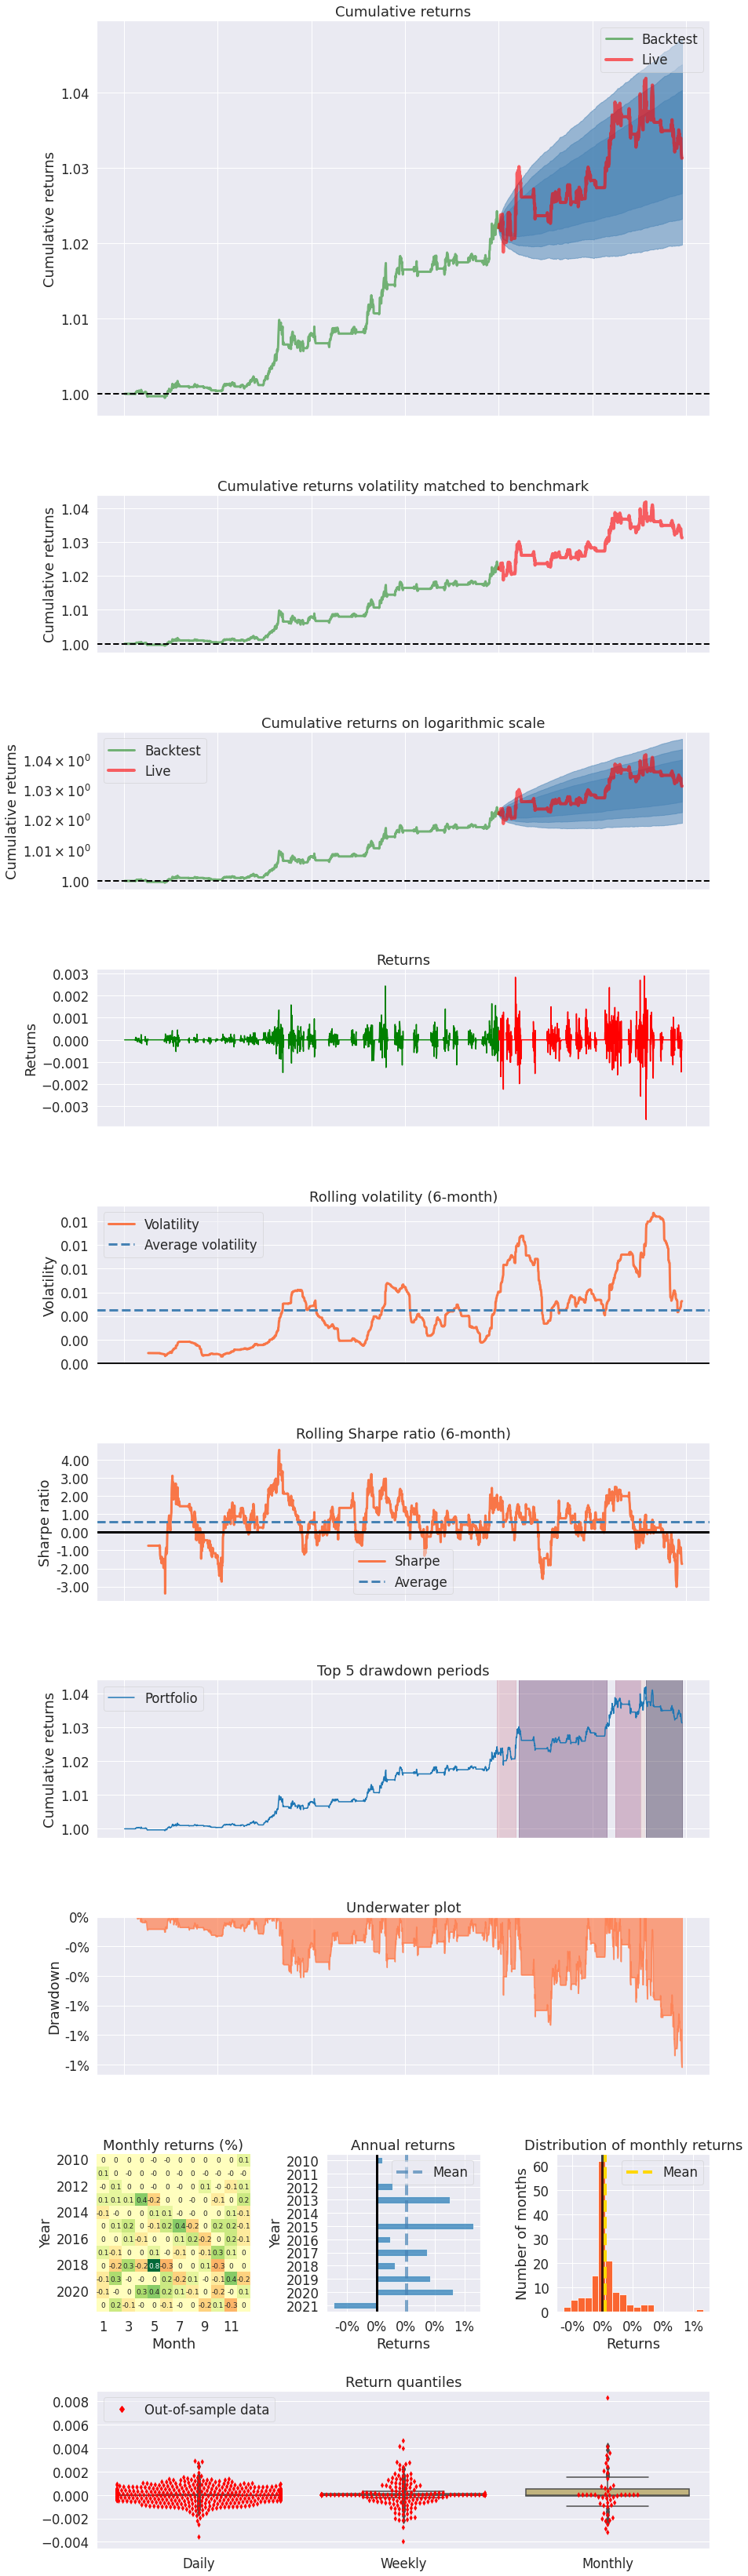

In [17]:
fig = pf.create_returns_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    # gross_lev=gross_lev,
    live_start_date='2018-01-01',  # This date is for starting out-of-sample
    # round_trips=True,
    return_fig=True
    )

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.02,2021-02-22,2021-11-29,NaT,NaN
1,0.73,2018-06-08,2019-02-08,2020-04-20,487
2,0.58,2020-06-26,2020-12-07,2021-01-08,141
3,0.53,2017-12-18,2018-02-06,2018-05-11,105
4,0.46,2021-01-08,2021-01-28,2021-02-09,23


Stress Events,mean,min,max
US downgrade/European Debt Crisis,0.00%,0.00%,0.00%
Fukushima,0.00%,0.00%,0.00%
EZB IR Event,0.00%,-0.02%,0.03%
Flash Crash,-0.01%,-0.01%,-0.00%
Apr14,0.00%,0.00%,0.00%
Oct14,0.00%,0.00%,0.00%
Fall2015,0.00%,-0.00%,0.01%
Recovery,0.00%,-0.05%,0.04%
New Normal,0.00%,-0.36%,0.29%


Top 10 long positions of all time,max
test,0.00%


Top 10 short positions of all time,max


Top 10 positions of all time,max
test,0.00%


<class 'NoneType'>


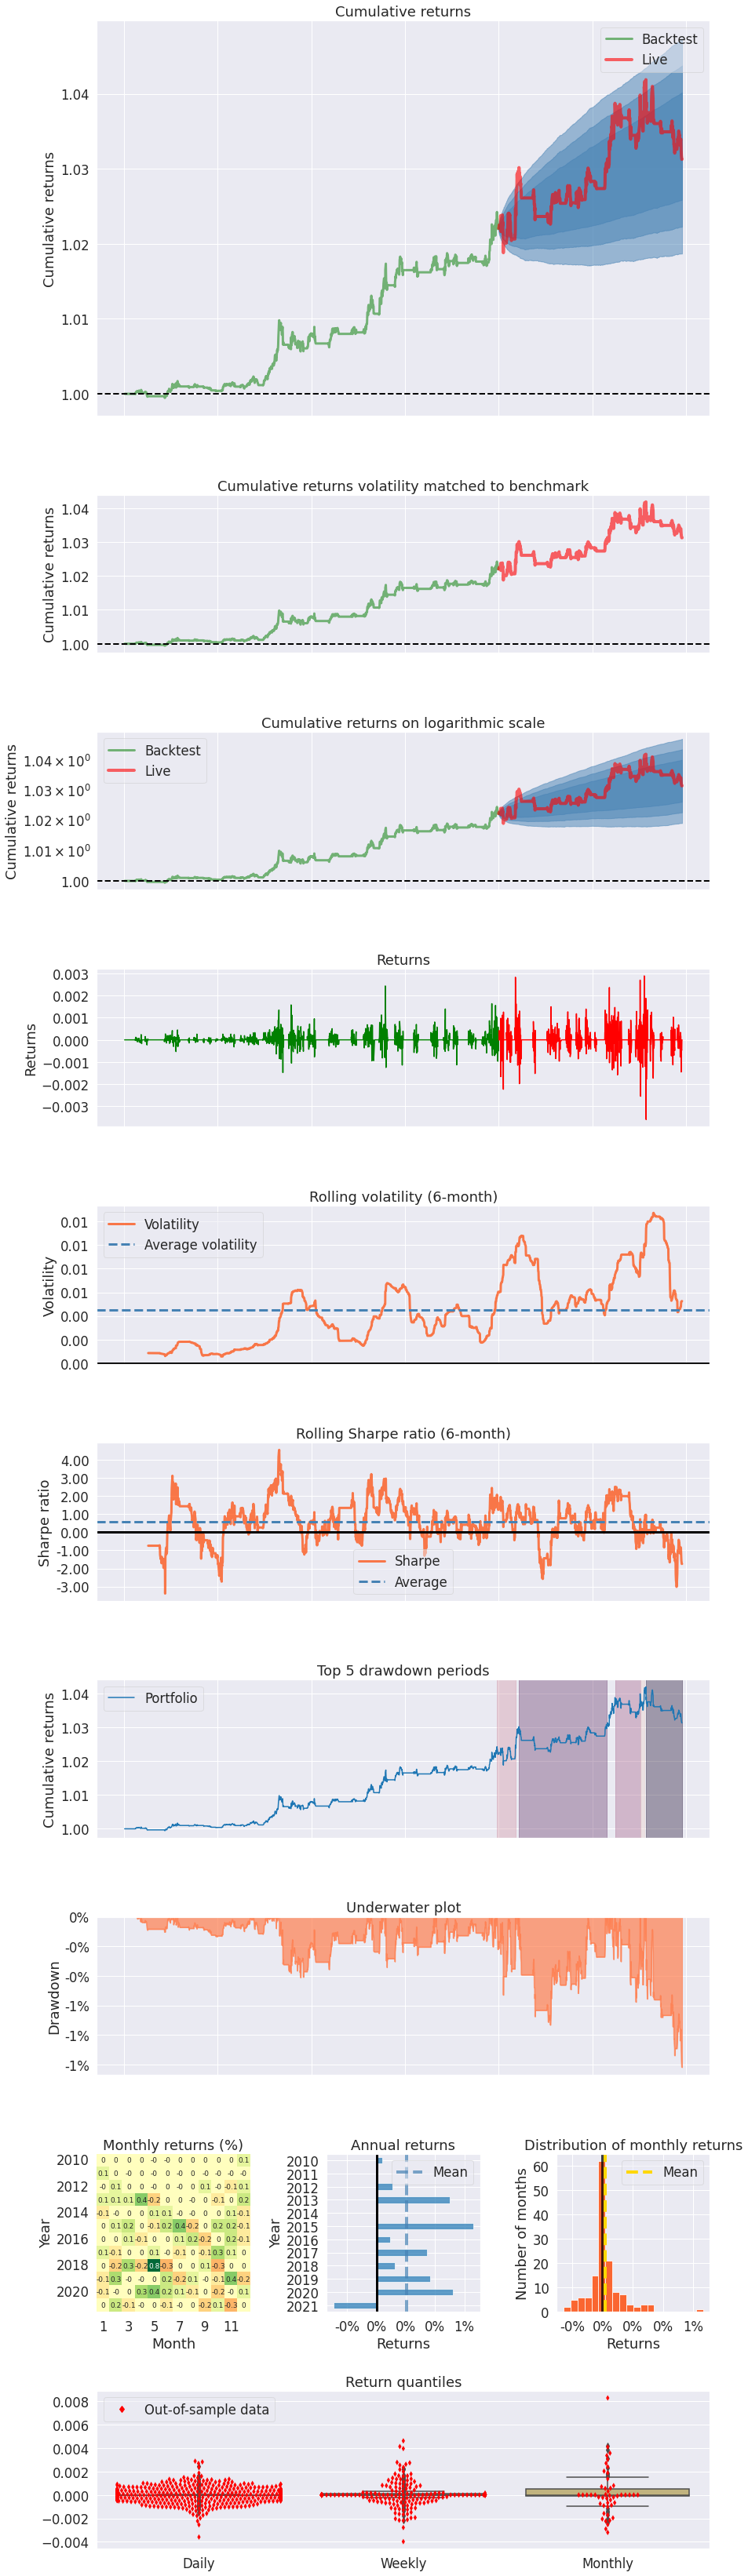

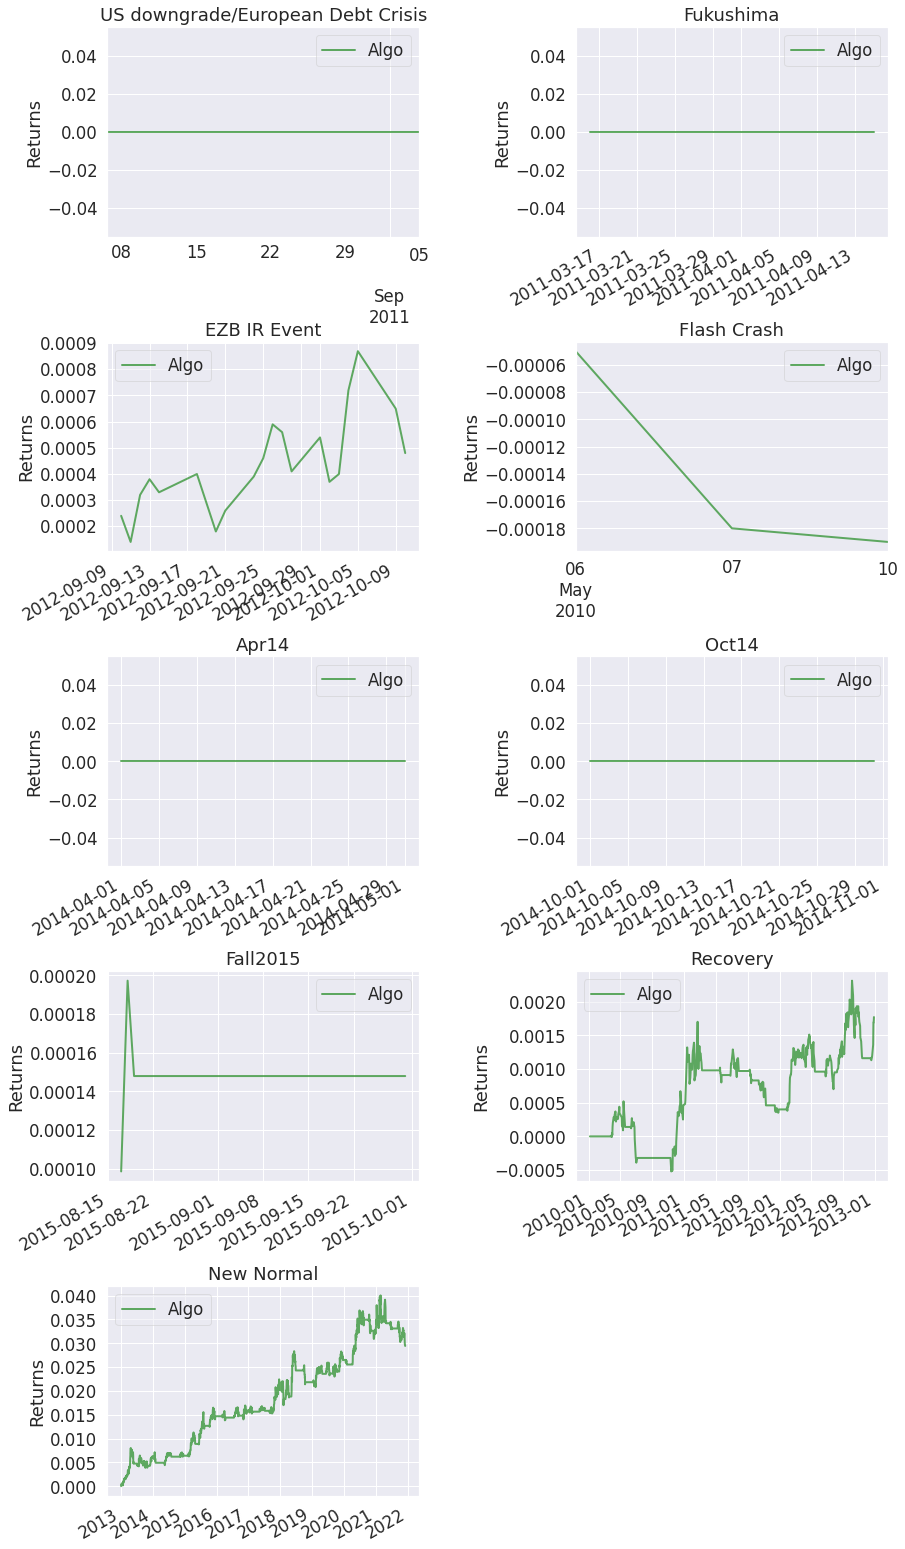

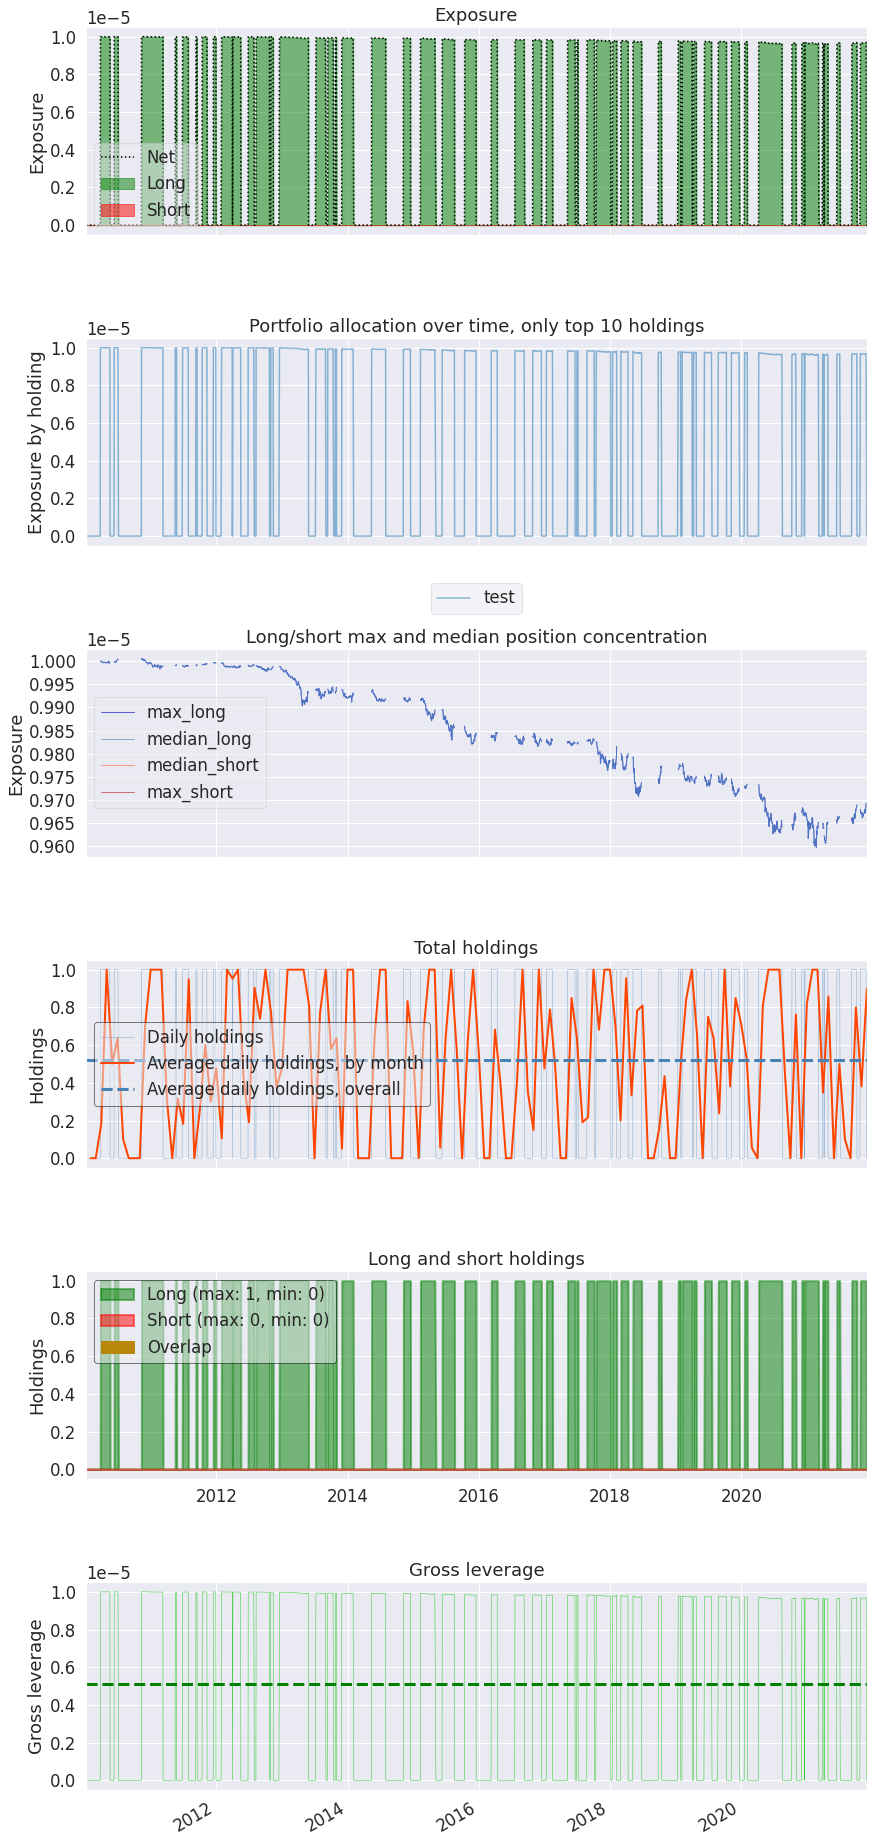

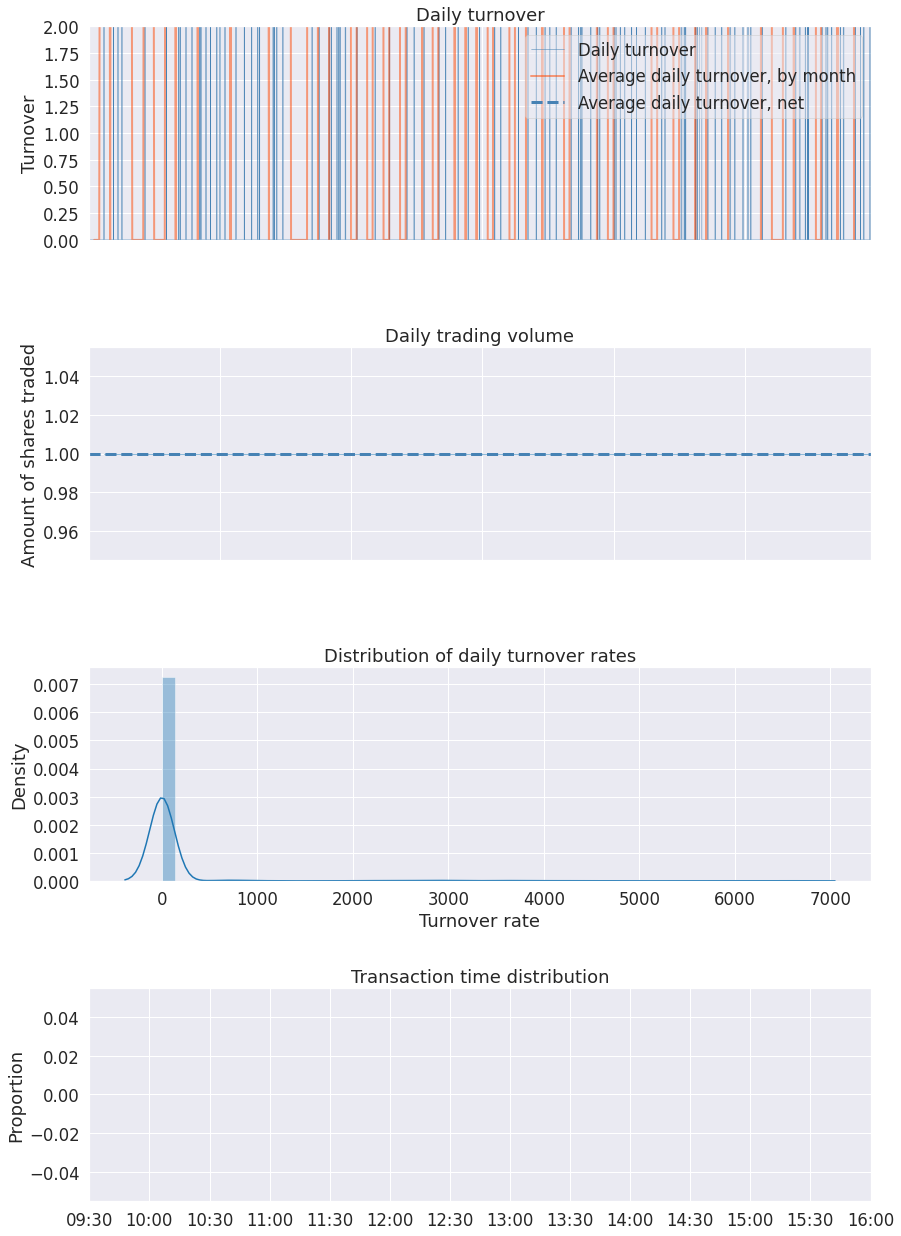

In [18]:
# show portfolio
portfolio = pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    # gross_lev=gross_lev,
    live_start_date='2018-01-01',  # This date is for starting out-of-sample
    # round_trips=True
    )
print(type(portfolio))
# portfolio

# testing

In [19]:
trade_dict = strat.analyzers.getbyname("trade_closed").get_analysis()
columns_df = [
        "Date Closed",
        "Ticker",
        "PnL",
        "PnL Comm",
        "Commission",
        "Days Open",
    ]
df = pd.DataFrame(trade_dict)
df = df.T
# df.columns = columns_df
df.head()

,0,1,2,3,4,5,6
1,2010-05-19,test,14.0,14.0,0.000001,54.0,2
2,2010-07-05,test,-46.0,-46.0,0.000001,24.0,2
3,2011-03-10,test,130.0,130.0,0.000001,120.0,2
4,2011-05-25,test,-7.0,-7.0,0.000001,8.0,2
5,2011-07-29,test,6.0,6.0,0.000001,32.0,2


In [20]:
trade_analyser = strat.analyzers.getbyname("trade_analyser").get_analysis()
trade_analyser.keys()
# # columns_df = [
# #         "Date Closed",
# #         "Ticker",
# #         "PnL",
# #         "PnL Comm",
# #         "Commission",
# #         "Days Open",
# #     ]
# df = pd.DataFrame(trade_analyser)
# df = df.T
# # df.columns = columns_df
# df
# trade_analyser.pnl

odict_keys(['total', 'streak', 'pnl', 'won', 'lost', 'long', 'short', 'len'])

In [21]:
positions = positions.reset_index()   
# df_position = df_position.rename(columns={'test': 'value'})
positions.tail()

,Datetime,test,cash
2930,2021-11-25 00:00:00+00:00,1.0,103219.999982
2931,2021-11-26 00:00:00+00:00,1.0,103174.999982
2932,2021-11-29 00:00:00+00:00,0.0,103126.999982
2933,2021-11-30 00:00:00+00:00,0.0,103126.999982
2934,2021-12-01 00:00:00+00:00,0.0,103126.999982


In [22]:
# strat.analyzers.getbyname('pyfolio').get_analysis().DrawDown()

In [23]:
analyse = strat.analyzers.getbyname('pyfolio').get_analysis()
analyse.keys

<function OrderedDict.keys>

In [24]:
# trade_dict = strat.analyzers.getbyname("pyfolio").get_analysis()
# columns_df = [
#         "Date Closed",
#         "Ticker",
#         "PnL",
#         "PnL Comm",
#         "Commission",
#         "Days Open",
#     ]

# df = pd.DataFrame(trade_dict)
# df = df.T
# df
# # df.columns = columns_df

In [25]:
cerebro.__dict__

{'_broker': <backtrader.brokers.bbroker.BackBroker at 0x7fe0f24f3b10>,
 '_dataid': count(2),
 '_dolive': False,
 '_dooptimize': False,
 '_dopreload': True,
 '_doreplay': False,
 '_dorunonce': True,
 '_event_stop': False,
 '_exactbars': 0,
 '_fhistory': None,
 '_ohistory': [],
 '_pretimers': [],
 '_signal_accumulate': False,
 '_signal_concurrent': False,
 '_signal_strat': (None, None, None),
 '_timers': [],
 '_timerscheat': [],
 '_tradingcal': None,
 'analyzers': [(backtrader.analyzers.pyfolio.PyFolio,
   (),
   {'_name': 'pyfolio'}),
  (__main__.TradeClosed, (), {'_name': 'trade_closed'}),
  (backtrader.analyzers.drawdown.DrawDown, (), {'_name': 'drawdown'}),
  (backtrader.analyzers.tradeanalyzer.TradeAnalyzer,
   (),
   {'_name': 'trade_analyser'})],
 'datacbs': [],
 'datas': [<backtrader.feeds.pandafeed.PandasData at 0x7fe0f24fb590>],
 'datasbyname': OrderedDict([('test',
               <backtrader.feeds.pandafeed.PandasData at 0x7fe0f24fb590>)]),
 'feeds': [],
 'indicators': [],
 'o

In [26]:
from backtrader.plot.plot import Plot_OldSync
plotter = Plot_OldSync

In [27]:
figs = []
for stratlist in cerebro.runstrats:
    for si, strat in enumerate(stratlist):
        print(si, strat)
        # rfig = plotter.plot(strategy=strat, figid=si * 100,
        #                     numfigs=1, iplot=True
                            # start=start, end=end, use=use
                            # )
        # pfillers=pfillers2)

        # figs.append(rfig)

    # plotter.show()

0 <__main__.SmaCross object at 0x7fe0f25d6e90>


In [28]:
inds = strat.getindicators()

In [29]:
strat.getindicators_lines()[0].array[:]
strat.getindicators_lines()[0]._getlines()

('sma',)

In [30]:
print(strat.getindicators_lines()[0].array.tolist())
print(strat.getindicators_lines()[1].array.tolist())
print(strat.getindicators_lines()[2].array.tolist())
print(strat.getindicators_lines()[0]._getlines()[0])
len(strat.getindicators_lines())

[nan, nan, nan, nan, nan, nan, nan, nan, nan, 373.3, 374.3, 374.9, 375.5, 375.7, 375.3, 375.1, 374.7, 374.9, 374.7, 373.9, 373.0, 372.1, 371.0, 370.1, 369.4, 368.4, 368.1, 366.8, 365.6, 364.3, 362.0, 360.7, 358.7, 357.1, 355.4, 354.5, 352.5, 350.0, 346.0, 342.6, 339.3, 335.1, 332.2, 329.2, 326.6, 323.8, 323.1, 323.9, 326.4, 327.8, 329.4, 331.2, 332.0, 335.1, 338.3, 341.4, 343.8, 345.0, 347.0, 349.1, 352.3, 356.1, 361.2, 364.2, 367.0, 369.8, 372.9, 376.7, 379.3, 381.3, 382.3, 383.1, 382.9, 382.8, 382.9, 383.1, 383.2, 383.3, 384.6, 385.8, 386.7, 386.7, 385.6, 384.2, 382.4, 382.6, 384.5, 385.2, 383.6, 382.2, 380.7, 378.9, 376.7, 374.6, 371.5, 366.1, 359.6, 353.4, 349.8, 350.2, 349.7, 351.3, 354.7, 356.9, 362.1, 367.8, 372.7, 378.0, 383.9, 385.8, 389.0, 390.3, 391.9, 394.9, 396.1, 397.0, 397.2, 395.6, 390.2, 385.1, 379.6, 374.2, 368.7, 364.1, 360.5, 355.7, 351.3, 348.7, 347.8, 347.2, 347.3, 347.1, 346.3, 343.0, 338.9, 338.3, 337.2, 335.5, 335.1, 334.4, 333.0, 332.3, 332.2, 333.0, 334.4, 33

3

In [31]:
strat.getindicators_lines()[0].params._getvalues()

[10]

In [32]:
for lineidx in range(ind.size()):
    line = ind.lines[lineidx]
    linealias = ind.lines._getlinealias(lineidx)
    # lineplotinfo = getattr(ind.plotlines, '_%d' % lineidx, None)

NameError: ignored

In [ ]:
print(linealias)
print(lineplotinfo)

In [ ]:
dir(strat.getindicators_lines()[0])

In [ ]:
inds = strat.getindicators()
ind = inds[0]
st_dtime = strat.lines.datetime.plot()
ind_data = ind.array[:]
ind_data

In [ ]:
# dir(strat)

In [ ]:
trade_dict = pyfoliozer.get_analysis()
trade_dict.keys()

In [ ]:
type(trade_dict)

In [ ]:
ind.plotlines.__dict__

In [ ]:
# len(ind.lines.lines[0].array.tolist())
pyfoliozer.datas[0]._dataname.reset_index().Date.values

In [ ]:
# print(ind.lines.lines[0].array.tolist())
# print(ind.lines.lines[1].array)
# print(ind.lines.lines[2].array)

In [ ]:
ind.lines._getlines()

In [ ]:
# raw data
open = strat.data_open.array
high = strat.data_high.array

# trades
trades = [str(trade).splitlines() for trade in list(strat._trades.values())[0][0]]

# orders
orders = [str(order).splitlines() for order in strat._orders]

In [ ]:
# trades

In [ ]:
# plt.plot(strat.analyzers.getbyname('pyfolio').data0_volume.array)
list(strat.analyzers.getbyname('pyfolio').__dict__.keys())

In [ ]:
strat.analyzers.getbyname('pyfolio').datas[0]._dataname.reset_index()

In [ ]:
strat.analyzers.getbyname('pyfolio').__dict__.keys()

In [ ]:
return_ordereddict = strat.analyzers.getbyname('pyfolio')._returns.rets
df_return = pd.DataFrame.from_dict(return_ordereddict, orient="index").reset_index()
df_return = df_return.rename(columns={"index":"date", 0:"returns"})
df_return

In [ ]:
df_rawdata = strat.analyzers.getbyname('pyfolio').datas[0]._dataname.reset_index()
df_rawdata.head()

In [ ]:
df_return.count(), df_rawdata.count()

In [ ]:
list(strat.analyzers.getbyname('pyfolio').strategy.__dict__.keys())

In [ ]:
# strat.analyzers.getbyname('pyfolio').strategy.boll.lines.lines[0].array
strat.analyzers.getbyname('pyfolio').strategy.lines.lines[0].array

In [ ]:
strat.analyzers.getbyname('pyfolio').strategy.line

In [ ]:
# strat.analyzers.getbyname('pyfolio').strategy._trades

In [ ]:
type(strat.analyzers.getbyname('pyfolio')._transactions.rets)
transactions_ordereddictlist = strat.analyzers.getbyname('pyfolio')._transactions.rets
df_transactions = pd.DataFrame(transactions_ordereddictlist, columns=transactions_ordereddictlist.keys())
df_transactions = df_transactions.explode(list(df_transactions.columns)).T.reset_index()
df_transactions.columns = df_transactions.iloc[0]
df_transactions = df_transactions[1:]
df_transactions

In [ ]:
df_transactions.price

In [ ]:
strat.analyzers.getbyname('pyfolio').data_datetime.array

In [ ]:
# cerebro.plot(savefig=True, figfilename='backtrader-plot.png')

In [ ]:
cerebro.plot()

In [ ]:
# plot backtest results
b = Bokeh(style='bar', plot_mode='single', scheme=Tradimo())
cerebro.plot(b)

In [ ]:
# cerebro.plot(b)

In [ ]:
fig = pf.create_returns_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    # gross_lev=gross_lev,
    live_start_date='2021-01-01',  # This date is for starting out-of-sample
    # round_trips=True,
    return_fig=True
    )

In [ ]:
type(fig)
plt.savefig('fig_portfo.png', format="png")

In [ ]:
fig

In [ ]:
from collections import OrderedDict
import empyrical as ep
from pyfolio.utils import (APPROX_BDAYS_PER_MONTH,
                    MM_DISPLAY_UNIT)
perf_func = pf.timeseries.perf_stats
live_start_date='2021-01-01'
factor_returns=None
turnover_denom='AGB'

perf_stats_all = perf_func(
    returns,
    factor_returns=factor_returns,
    positions=positions,
    transactions=transactions,
    turnover_denom=turnover_denom)

date_rows = OrderedDict()
if len(returns.index) > 0:
    date_rows['Start date'] = returns.index[0].strftime('%Y-%m-%d')
    date_rows['End date'] = returns.index[-1].strftime('%Y-%m-%d')

if live_start_date is not None:
    live_start_date = ep.utils.get_utc_timestamp(live_start_date)
    returns_is = returns[returns.index < live_start_date]
    returns_oos = returns[returns.index >= live_start_date]

    positions_is = None
    positions_oos = None
    transactions_is = None
    transactions_oos = None

    if positions is not None:
        positions_is = positions[positions.index < live_start_date]
        positions_oos = positions[positions.index >= live_start_date]
        if transactions is not None:
            transactions_is = transactions[(transactions.index <
                                            live_start_date)]
            transactions_oos = transactions[(transactions.index >
                                              live_start_date)]

    perf_stats_is = perf_func(
        returns_is,
        factor_returns=factor_returns,
        positions=positions_is,
        transactions=transactions_is,
        turnover_denom=turnover_denom)

    perf_stats_oos = perf_func(
        returns_oos,
        factor_returns=factor_returns,
        positions=positions_oos,
        transactions=transactions_oos,
        turnover_denom=turnover_denom)
    if len(returns.index) > 0:
        date_rows['In-sample months'] = int(len(returns_is) /
                                            APPROX_BDAYS_PER_MONTH)
        date_rows['Out-of-sample months'] = int(len(returns_oos) /
                                                APPROX_BDAYS_PER_MONTH)

    perf_stats = pd.concat(OrderedDict([
        ('In-sample', perf_stats_is),
        ('Out-of-sample', perf_stats_oos),
        ('All', perf_stats_all),
    ]), axis=1)
perf_stats

In [ ]:
import os
os.getcwd() 

In [ ]:
# show portfolio
portfolio = pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    # gross_lev=gross_lev,
    live_start_date='2021-01-01',  # This date is for starting out-of-sample
    # round_trips=True
    )
print(type(portfolio))
# portfolio

# Unmount and flush google drive

In [ ]:
# from google.colab import drive
# drive.flush_and_unmount()